In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path

classLabels = ["Headphones", "Welding helmet", "Welder's clothing", "Helmet",
               "Vest", "Glasses", "Mask", "Gloves", "Shoes", "Coveralls", "Chinstrap"]
print(torch.__version__)

1.7.0+cu101


## Download Data

In [17]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
!unzip /content/drive/MyDrive/ml/dataset.zip

Archive:  /content/drive/MyDrive/ml/dataset.zip
replace annotations.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: annotations.xml         
 extracting: images/out100.jpg       
 extracting: images/out105.jpg       
 extracting: images/out78.jpg        
 extracting: images/out107.jpg       
 extracting: images/out132.jpg       
 extracting: images/out88.jpg        
 extracting: images/out89.jpg        
 extracting: images/out43.jpg        
 extracting: images/out48.jpg        
 extracting: images/out22.jpg        
 extracting: images/out130.jpg       
 extracting: images/out137.jpg       
 extracting: images/out30.jpg        
 extracting: images/out93.jpg        
 extracting: images/out158.jpg       
 extracting: images/out44.jpg        
 extracting: images/out102.jpg       
 extracting: images/out147.jpg       
 extracting: images/out139.jpg       
 extracting: images/out56.jpg        
 extracting: images/out71.jpg        
 extracting: images/out25.jpg        
 extracting: 

In [52]:
import xml.etree.ElementTree as ET
from PIL import Image 
from pathlib import Path

Path("/content/newdataset").mkdir(parents=True, exist_ok=True)

tree = ET.parse('annotations.xml')
root = tree.getroot()

def bool_to_int(s):
  if s == "true":
    return '1';
  return '-1';

def convertXML():
  data = []

  headphones, welding_helmet, welders_clothing, helmet, vest, glasses, mask, gloves, shoes, coveralls, chinstrap = "","","","","","","","","","",""

  for child in root.iter("box"):
   
    for subelement in child:
      
      if subelement.attrib.get("name") == "Headphones":
          headphones = bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Chinstrap":
          chinstrap=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Vest":
          vest=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Mask":
          mask=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Glasses":
          glasses=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Helmet":
          helmet=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Gloves":
          gloves=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Shoes":
          shoes=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Welder's clothing":
          welders_clothing=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Coveralls":
          coveralls=bool_to_int(subelement.text)
      if subelement.attrib.get("name") == "Welding helmet":
          welding_helmet = bool_to_int(subelement.text)
    
    vector = '[' + headphones + ', ' + welding_helmet + ', ' + welders_clothing + ', ' + helmet + ', ' + vest + ', ' + glasses + ', ' + mask + ', ' + gloves + ', ' + shoes + ', ' + coveralls + ', ' + chinstrap + ']'
    data.append(vector)
  
  
  return data

newdataset = convertXML()

def writeData(newdataset):
  f= open("labels.json","w+")

  for i in range(len(newdataset)):
      f.write((str(newdataset[i]) + "\n"))

  f.close()

writeData(newdataset)

def cropImage():
  k = 1

  for child in root.iter("image"):
    xtlarr = []
    ytlarr = []
    xbrarr = []
    ybrarr = []

    imgname = child.attrib.get("name")
    # print(child.attrib.get("name"))

    for subelement in child:
      xtlarr.append(float(subelement.attrib.get('xtl')))
      ytlarr.append(float(subelement.attrib.get('ytl')))
      xbrarr.append(float(subelement.attrib.get('xbr')))
      ybrarr.append(float(subelement.attrib.get('ybr')))
    
    #crop image
    im = Image.open(r"/content/images/" + imgname)

    for i in range(len(xtlarr)):
      # Cropped image of above dimension 
      # (It will not change orginal image) 
      im1 = im.crop((xtlarr[i], ytlarr[i], xbrarr[i], ybrarr[i])) 
      
      im1 = im1.save("/content/newdataset/" + str(k) + ".jpg")
      k += 1
      
    
cropImage()


## Structure the data

In [53]:
!ls

annotations.xml  drive	 labels.json	      newdataset
data.csv	 images  LatestCheckpoint.pt  sample_data


In [54]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("newdataset").iterdir()])})
df.image = df.image.astype(np.str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    print(len(s[0]))
    print(len(df))
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))
del df

image    object
dtype: object
11
334
    image  Headphones  Welding helmet  ...  Shoes  Coveralls  Chinstrap
0   1.jpg           0               0  ...      1          1          0
1   2.jpg           0               0  ...      0          1          0
2   3.jpg           0               0  ...      0          1          0
3   4.jpg           0               0  ...      1          1          0
4   5.jpg           0               0  ...      1          1          0
5   6.jpg           0               0  ...      1          1          0
6   7.jpg           0               0  ...      0          1          0
7   8.jpg           0               0  ...      0          1          0
8   9.jpg           0               0  ...      0          1          0
9  10.jpg           0               0  ...      1          1          0

[10 rows x 12 columns]


## Visulaize the data


### Data distribution

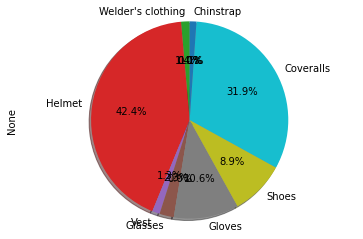

In [55]:
df = pd.read_csv("data.csv")
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

### Correlation between different classes

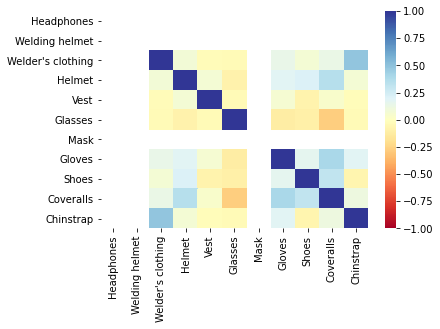

In [56]:
import seaborn as sns
sns.heatmap(df.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
# looks like there is no correlation between the labels

### Visualize images

53.jpg


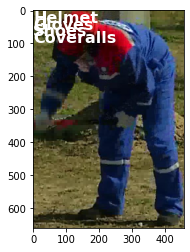

In [57]:
def visualizeImage(idx):
  fd = df.iloc[idx]
  image = fd.image
  label = fd[1:].tolist()
  print(image)
  image = Image.open("newdataset/"+image)
  fig,ax = plt.subplots()
  ax.imshow(image)
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  plt.show()

visualizeImage(52)

In [58]:
#Images in the dataset have different sizes to lets take a mean size while resizing 224*224
l= []
for i in df.image:
  with Image.open(Path("newdataset")/i) as f:
    l.append(f.size)
np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([370.83832335, 542.82934132]), array([198.5, 452.5]))

## Create Data pipeline

In [59]:
class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)
    
    if self.transforms is not None:
      image = self.transforms(image)
    return image,label
  
  def __len__(self):
    return len(self.df)

In [60]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("newdataset") , transform)
valid_no = int(len(dataset)*0.12) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 294 valset len 40


## Model Definition

In [61]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

2048


In [62]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Optimizer and Criterion

In [63]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

## Training

In [64]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [65]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epochs:  10%|█         | 1/10 [00:03<00:31,  3.50s/it]

['train Loss: 0.7216 Acc: 0.2832', 'val Loss: 0.6603 Acc: 0.3345']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
Epochs:  20%|██        | 2/10 [00:06<00:27,  3.47s/it]

['train Loss: 0.6275 Acc: 0.3803', 'val Loss: 0.6469 Acc: 0.4121']


Epochs:  30%|███       | 3/10 [00:10<00:24,  3.45s/it]

['train Loss: 0.5375 Acc: 0.4736', 'val Loss: 0.4090 Acc: 0.6676']


Epochs:  40%|████      | 4/10 [00:13<00:20,  3.44s/it]

['train Loss: 0.3988 Acc: 0.6185', 'val Loss: 0.2441 Acc: 0.8033']


Epochs:  50%|█████     | 5/10 [00:17<00:17,  3.43s/it]

['train Loss: 0.2509 Acc: 0.7244', 'val Loss: 0.1767 Acc: 0.7968']


Epochs:  60%|██████    | 6/10 [00:20<00:13,  3.43s/it]

['train Loss: 0.1368 Acc: 0.7638', 'val Loss: 0.1689 Acc: 0.8051']


Epochs:  70%|███████   | 7/10 [00:23<00:10,  3.42s/it]

['train Loss: 0.1065 Acc: 0.7960', 'val Loss: 0.1403 Acc: 0.8018']


Epochs:  80%|████████  | 8/10 [00:27<00:06,  3.43s/it]

['train Loss: 0.0923 Acc: 0.7925', 'val Loss: 0.1380 Acc: 0.7871']


Epochs:  90%|█████████ | 9/10 [00:30<00:03,  3.43s/it]

['train Loss: 0.0822 Acc: 0.7903', 'val Loss: 0.1265 Acc: 0.7785']


Epochs: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]

['train Loss: 0.0818 Acc: 0.8058', 'val Loss: 0.1199 Acc: 0.8037']


## Saving & Loading model

In [66]:
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
  checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()

In [67]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.0009999999999999983
    weight_decay: 0
)

## Visualizing some end result

In [68]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2  


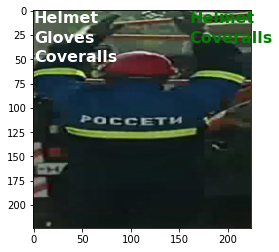

In [70]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(actual,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
  classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="green", fontsize=16, weight='bold')

  plt.show()

visualize(image[1] , label[1].tolist() , output[1].tolist())

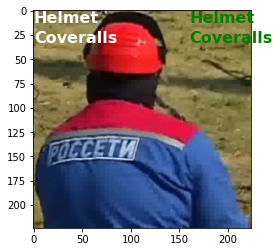

In [71]:
visualize(image[0] , label[0].tolist() , output[0].tolist())

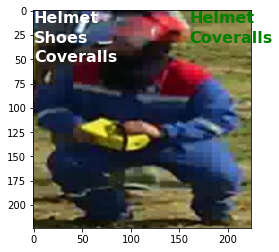

In [72]:
visualize(image[2] , label[2].tolist() , output[2].tolist())

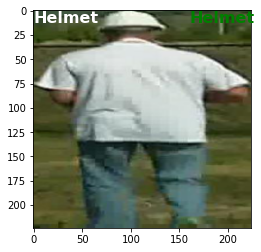

In [73]:
visualize(image[7] , label[7].tolist() , output[7].tolist())